## Exploratory Data Analysis
** Fix visuals later **

In [1]:
# env packages: standard env, +pysal, + jupyter, + matplotlib
#### import libraries ####
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.explore import esda
from pysal.lib import weights
from statistics import mean

os.chdir('C:/Users/offne/Documents/Dissertation')
os.getcwd()


'C:\\Users\\offne\\Documents\\Dissertation'

## 1. Read Data

In [2]:
# READ FOOD SECURITY DATA
FS = pd.read_csv('Data\predicting_food_crises_data.csv')
# Select country of interest
country = 'Burkina Faso'
FS.drop(FS.loc[FS['country'] != country].index, inplace=True)
# Reset index
FS = FS.reset_index()
FS = FS.drop(['index'], axis=1)
FS.head()

,country,admin_code,admin_name,centx,centy,year_month,year,month,fews_ipc,fews_ha,...,et_mean,et_anom,acled_count,acled_fatalities,p_staple_food,area,cropland_pct,pop,ruggedness_mean,pasture_pct
0,Burkina Faso,303,Sissili,-2.230901,11.30098,2007_01,2007,1,NaN,NaN,...,0.782140,-0.195788,0,0,0.737295,6982.097,76.98947,207340.7375,6643.468,0.0
1,Burkina Faso,303,Sissili,-2.230901,11.30098,2007_02,2007,2,NaN,NaN,...,0.286041,-0.198063,0,0,0.731854,6982.097,76.98947,207340.7375,6643.468,0.0
2,Burkina Faso,303,Sissili,-2.230901,11.30098,2007_03,2007,3,NaN,NaN,...,0.300348,-0.338840,0,0,0.739055,6982.097,76.98947,207340.7375,6643.468,0.0
3,Burkina Faso,303,Sissili,-2.230901,11.30098,2007_04,2007,4,NaN,NaN,...,1.981821,-0.023387,0,0,0.735403,6982.097,76.98947,207340.7375,6643.468,0.0
4,Burkina Faso,303,Sissili,-2.230901,11.30098,2007_05,2007,5,NaN,NaN,...,5.608847,1.667978,0,0,0.767469,6982.097,76.98947,207340.7375,6643.468,0.0


<AxesSubplot:>

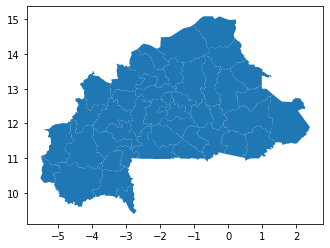

In [3]:
# READ COUNTRY SHAPEFILE (admin 2 level)
shape = gpd.read_file('Data\Shape\gadm36_BFA_2.shp')
shape = shape.drop(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2'], axis=1)
shape.rename(columns = {'NAME_2':'admin_name'}, inplace = True)
shape['admin_name'] = shape['admin_name'].astype(str)
shape.plot()

## 2. Clean data

In [4]:
# Remove all predictors except fews_ipc
FS = FS.drop(['centx', 'centy', 'fews_ha', 'fews_proj_near', 'fews_proj_near_ha', 'fews_proj_med', 'fews_proj_med_ha'], axis=1)
# Remove anom variables to optimize independence
FS = FS.drop(['ndvi_anom', 'rain_anom', 'et_anom'], axis=1)

# Remove unnecessary years
FS.drop(FS.index[FS['year'] == 2007], inplace=True)
FS.drop(FS.index[FS['year'] == 2008], inplace=True)
FS.drop(FS.index[FS['year'] == 2009], inplace=True)
FS.drop(FS.index[FS['year'] == 2020], inplace=True)

# Extend NA's where applicable
FS.isnull().sum()
FS['fews_ipc'] = FS['fews_ipc'].fillna(method='ffill')
FS['et_mean'] = FS['et_mean'].fillna(method='ffill')

# Check strings and fix differences
l = set(FS['admin_name'].tolist())
x = set(shape['admin_name'].tolist())
print(list(l - x))
print(list(x - l))
shape['admin_name'] = shape['admin_name'].str.replace('é','e')
shape['admin_name'] = shape['admin_name'].str.replace('è','e')
shape['admin_name'] = shape['admin_name'].str.replace('Komandjoari','Komonjdjari')

['Comoe', 'Passore', 'Leraba', 'Koulpelogo', 'Sanguie', 'Kenedougou', 'Zoundweogo', 'Seno', 'Komonjdjari', 'Bazega', 'Bale', 'Boulkiemde', 'Kourweogo']
['Kourwéogo', 'Zoundwéogo', 'Balé', 'Léraba', 'Komandjoari', 'Comoé', 'Koulpélogo', 'Bazèga', 'Sanguié', 'Kénédougou', 'Séno', 'Passoré', 'Boulkiemdé']


In [5]:
# Merge data on admin_name
df = pd.merge(shape, FS, on='admin_name')
print(list(df.columns))
# Reorder columns
df = df[['country', 'admin_code', 'admin_name', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'geometry']]
# df = df.sort_values('admin_name')


['admin_name', 'geometry', 'country', 'admin_code', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct']


In [6]:
#### ** Data manipulations ** ####
y = df.groupby(['admin_name', 'year'])['fews_ipc'].mean().reset_index()
m = df.groupby(['admin_name', 'month'])['fews_ipc'].mean().reset_index()
ym = df.groupby(['admin_name', 'year_month'])['fews_ipc'].mean().reset_index()
# transpose matrix & row means
year_m = y.pivot(index='admin_name', columns='year', values='fews_ipc')
month_m = m.pivot(index='admin_name', columns='month', values='fews_ipc')
yearmonth_m = ym.pivot(index='admin_name', columns='year_month', values='fews_ipc')

In [7]:
# month_m['mean'] = month_m.mean(axis=1)
# month_m.loc[len(month_m.index)] = month_m.mean(axis=0)

## 3. Exploratory Analysis

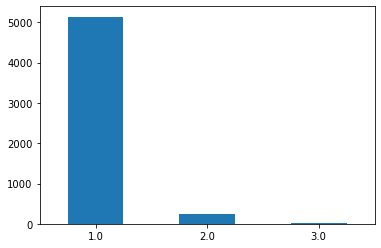

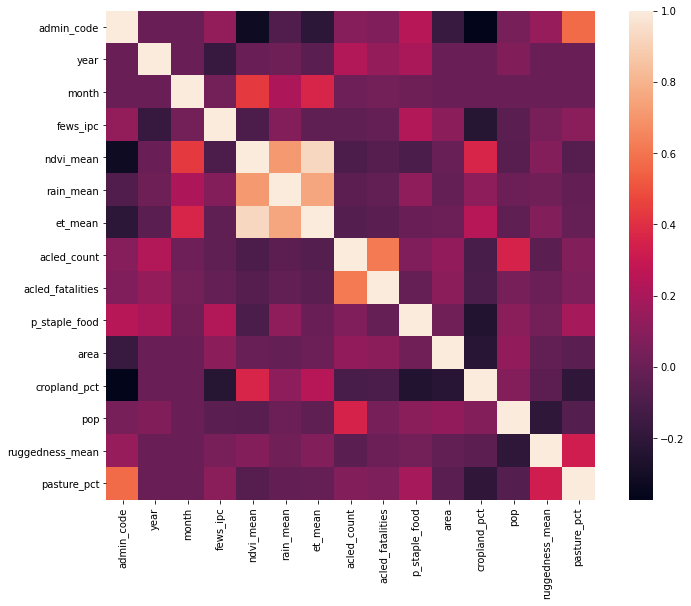

In [8]:
#### NON SPATIAL-TEMPORAL ANALYSIS ####

# Look at data
# print(df.describe())

# Examine predictive feature (few_ipc & flooding) - barplots
df['fews_ipc'].value_counts().plot.bar(rot=0)

# Examine correlation between features and target variable - corplots
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

## Spatial Analysis
Does it need a space lag or not?


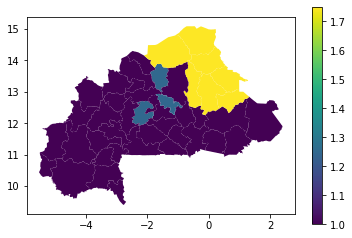

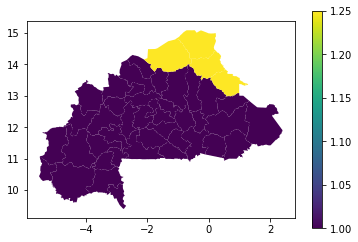

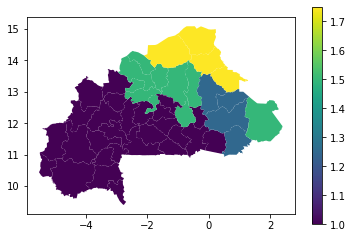

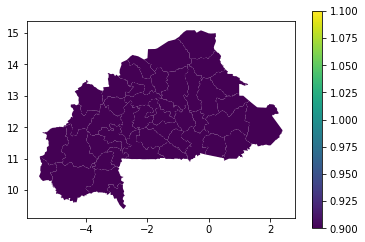

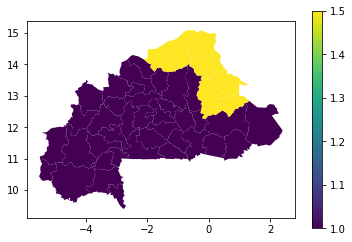

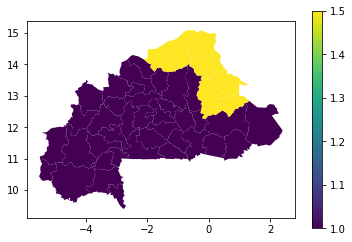

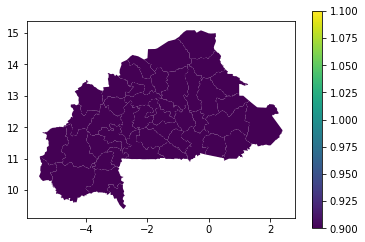

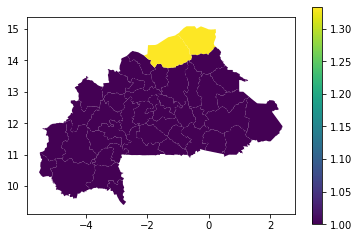

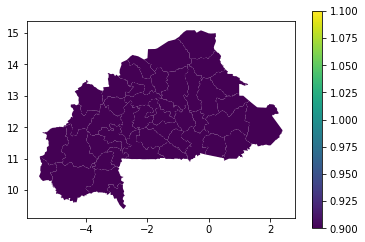

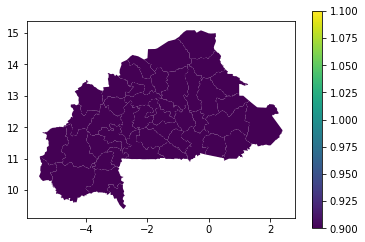

In [9]:
#### SPATIAL ANALYSIS ####
# Visuals: https://stackoverflow.com/questions/50435713/custom-legend-labels-geopandas-plot

# Spatial distribution over annual average
years = list(year_m.columns)
for i in years:
    t = y.groupby('year').get_group(i)
    dist = pd.merge(shape, t, on='admin_name')
    dist.plot(column='fews_ipc', cmap='viridis', legend=True)


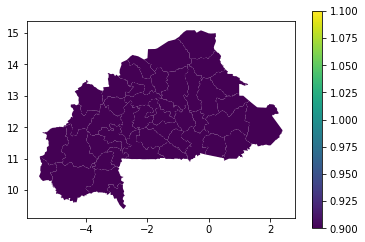

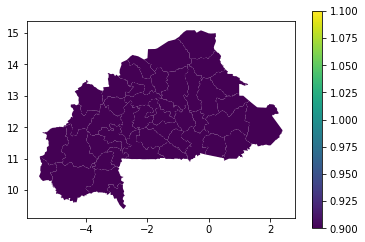

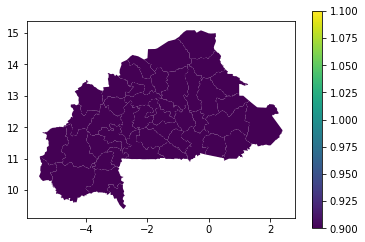

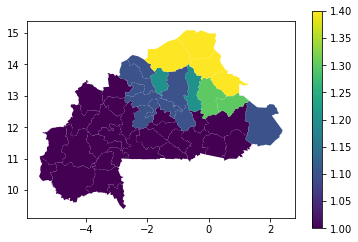

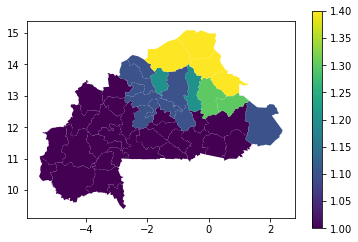

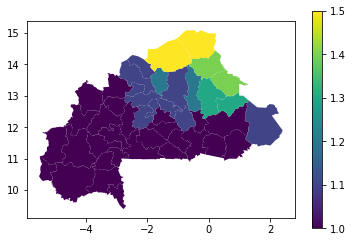

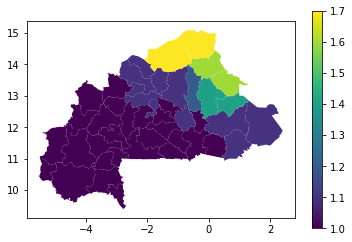

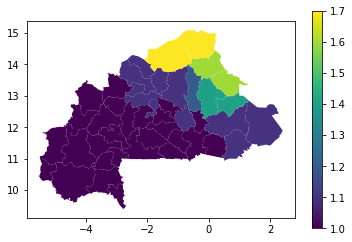

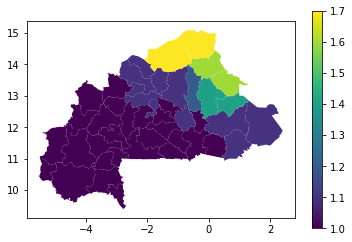

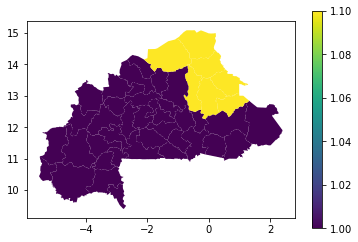

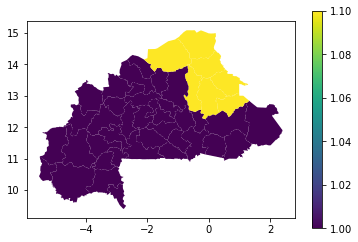

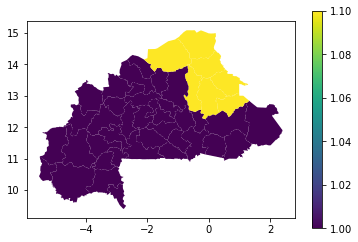

In [10]:
# Spatial distribution over monthly average
months = list(month_m.columns)
for i in months:
    t = m.groupby('month').get_group(i)
    dist = pd.merge(shape, t, on='admin_name')
    dist.plot(column='fews_ipc', cmap='viridis', legend=True)


In [11]:
# SOURCE: https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-autocorrelation

# Check Spatial Dependency
# --> Moran's Global I
w = weights.KNN.from_dataframe(shape, k=8) # Generate W from the GeoDataFrame
w.transform = 'R' # Row-standardization

# compute spatial lag of a given variable
lag = weights.spatial_lag.lag_spatial(w, year_m.mean(axis=1))
moran = esda.moran.Moran(year_m.mean(axis=1), w)
print('Morans I value: ', moran.I) # value of Moran’s I
print('P-value based on permutations: ', moran.p_sim) # (if permutations>0) p-value based on permutations (one-tailed) null: spatial randomness alternative: the observed I is extreme if it is either extremely greater or extremely lower than the values obtained based on permutations

Morans I value:  -0.06363333567841829
P-value based on permutations:  0.251


Given a confidence level of 95%, the global Moran’s I test had a p-value > -0.05225,
thus failing to reject the null hypothesis and suggesting that spatial autocorrelation in this dataset
is due to chance.

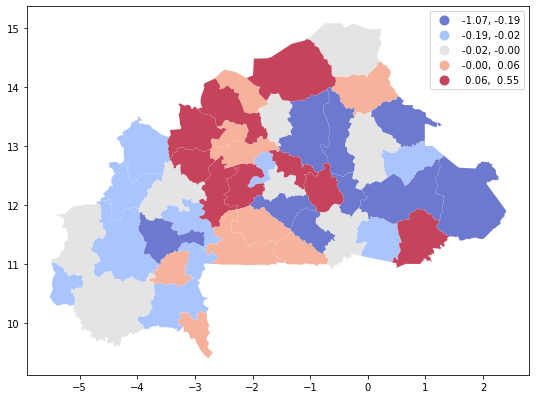

In [12]:
# --> Moran's Local I Clusters
local = esda.moran.Moran_Local(year_m.mean(axis=1), w)
# ax = sns.kdeplot(local.Is)
# sns.rugplot(local.Is, ax=ax)

f, ax = plt.subplots(1, figsize=(9,9))
shape['Is'] = local.Is
shape.plot(column='Is', cmap='coolwarm', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);

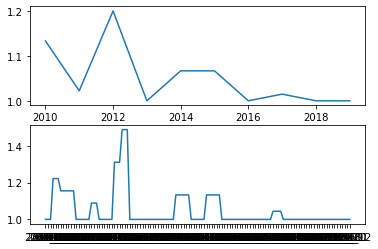

In [13]:
#### TEMPORAL ANALYSIS ####
# Look at the mean few_ipc across country over time (in years)
plt.figure()
plt.subplot(211)
q = year_m.mean(axis=0)
plt.plot(years, q)

# Look at the mean few_ipc across country over time (in months)
plt.subplot(212)
yearmonth = list(yearmonth_m.columns)
p = yearmonth_m.mean(axis=0)
plt.plot(yearmonth, p)
plt.show()

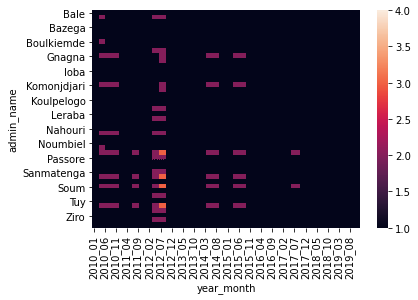

In [14]:
# Order heat map by admin food security means to examine effects
sns.heatmap(yearmonth_m, vmax=4);

C:\Users\offne\.conda\envs\diss\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\offne\.conda\envs\diss\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
C:\Users\offne\.conda\envs\diss\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<AxesSubplot:>

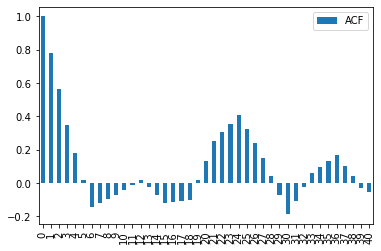

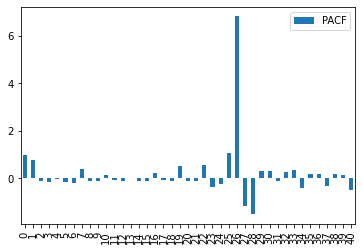

In [15]:
from statsmodels.tsa.stattools import acf, pacf

# Check Temporal Dependency
# --> ACF
acf =  acf(yearmonth_m.mean(axis=0))
acf1 = pd.DataFrame(acf)
acf1.columns = ['ACF']
acf1.plot(kind='bar')
# --> PACF
pacf =  pacf(yearmonth_m.mean(axis=0))
pacf1 = pd.DataFrame(pacf)
pacf1.columns = ['PACF']
pacf1.plot(kind='bar')

## 4. Model Pre-processing

Time Lags (depends on temporal analysis)

In [31]:
# Group by admin
groups = df.groupby('admin_name')

# i.e. Add lag of 6 for general time trends
timelag = {}
for admin, group in groups:
    group['timelag'] = group['fews_ipc'].shift(6)
    timelag[admin] = tuple(group['timelag'])

col = set(df['year_month'].tolist())
timelag1 = pd.DataFrame.from_dict(timelag)
timelag1 = timelag1.T
timelag1.columns = set(df['year_month'].tolist())
timelag1 = timelag1.stack(dropna = False).reset_index()
timelag1.columns = ['admin_name','year_month','timelag1']

In [32]:
# i.e. Add lag of 12 for seasonal time trends
timelag = {}
for admin, group in groups:
    group['timelag'] = group['fews_ipc'].shift(12)
    timelag[admin] = tuple(group['timelag'])

col = set(df['year_month'].tolist())
timelag2 = pd.DataFrame.from_dict(timelag)
timelag2 = timelag2.T
timelag2.columns = set(df['year_month'].tolist())
timelag2 = timelag2.stack(dropna = False).reset_index()
timelag2.columns = ['admin_name','year_month','timelag2']


Space lag

In [33]:
# !! Make sure not to include admin of concern in this !!
s = shape.sort_values('admin_name')
s = s.reset_index()
s = s.drop(['index'], axis=1)

In [34]:
# A. Spatial weight matrix
# Queen contiguity matrix (we consider observations that share a vertex to be neighbors)
wq = weights.contiguity.Queen.from_dataframe(s)
n = wq.neighbors
print(n)

{0: [32, 35, 39, 23, 12], 1: [33, 36, 22, 41, 30], 2: [17, 11, 23], 3: [6, 8, 42, 44, 13], 4: [7, 39, 11, 12, 31], 5: [18, 19, 24, 8, 10, 44], 6: [32, 35, 3, 20, 42, 13, 30], 7: [4, 21, 11, 14, 31], 8: [33, 3, 5, 44, 13, 19, 25, 28], 9: [34, 19, 40, 25, 10, 15], 10: [16, 18, 19, 5, 38, 9, 15], 11: [2, 4, 23, 7, 39, 14], 12: [0, 35, 4, 39, 31], 13: [3, 20, 6, 8, 28], 14: [11, 21, 7], 15: [40, 9, 10, 38], 16: [18, 10, 38], 17: [2, 26, 37, 23], 18: [16, 10, 5], 19: [5, 8, 25, 10, 9], 20: [28, 13, 6, 30], 21: [14, 7], 22: [1, 36, 41], 23: [0, 32, 2, 17, 39, 26, 11], 24: [42, 35, 44, 5], 25: [33, 34, 19, 36, 8, 9], 26: [32, 17, 37, 23, 30], 27: [31], 28: [33, 20, 8, 13, 30], 29: [34, 36], 30: [32, 1, 33, 37, 6, 41, 43, 20, 26, 28], 31: [27, 4, 12, 7], 32: [0, 35, 6, 23, 26, 30], 33: [1, 36, 8, 25, 28, 30], 34: [36, 40, 9, 29, 25], 35: [0, 32, 6, 24, 42, 12], 36: [1, 33, 34, 22, 25, 29], 37: [17, 41, 26, 43, 30], 38: [16, 10, 15], 39: [0, 4, 23, 11, 12], 40: [9, 34, 15], 41: [1, 37, 22, 43, 

In [35]:
# B. Extract list of neighbors for each admin_name
from itertools import chain

neighbors = []
for i in n:
    dist = s['admin_name'][i]
    l = []
    for j in n[i]:
        name = s['admin_name'][j]
        l.append(name)
    # neighbors.add(dist, l)
    neighbors.append({dist: l})

In [21]:
# C. For each list of neighbors (nest_list), at every time interval (df_m_matrix), take the neighbors average of fews_ipc

res = []
for item in range(45):
    l = list(neighbors[item].values())
    l = list(chain.from_iterable(l))
    d = list(neighbors[item].keys())
    d = d[0]
    timeseries = [d]
    for c, col in yearmonth_m.iteritems(): # iterate column numbers
        num = []
        for neigh in l:
            for r, row in yearmonth_m.iterrows():
                if r == neigh:
                    v = yearmonth_m.loc[r, c]
                    num.append(v)
        av = mean(num)
        timeseries.append(av)
    res.append(timeseries)

In [36]:
# D. Store nested averages in final data frame
c = list(yearmonth_m.columns)
c.insert(0, 'admin_name')
# r = list(yearmonth_m.index.values)
spacelag = pd.DataFrame(res)
spacelag.columns = c
spacelag = spacelag.set_index('admin_name')
spacelag = pd.melt(spacelag) #merge on index


In [38]:
# Merge timelag1, timelag2 and spacelag on index
df['spacelag'] = spacelag['value']
df['timelag1'] = timelag1['timelag1']
df['timelag2'] = timelag2['timelag2']
df = df[['country', 'admin_code', 'admin_name', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean',
         'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct',
         'pop', 'ruggedness_mean', 'pasture_pct', 'spacelag', 'timelag1', 'timelag2', 'geometry']]